# Predict with XAI-AGE - example





Connect your drive and load the data (XAI-AGE related data is available here: https://drive.google.com/drive/folders/1Geq3l28xagnDpKuI5Ip-OFYLzdY_e5hO?usp=sharing)

In [11]:
# Optimized for Colab-PRO. Free tier Colab can cause out of memory errors.

In [1]:
# Connect to your google drive to download the XAI-AGE model related files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Paureel/pnet.git

Cloning into 'pnet'...
remote: Enumerating objects: 1664, done.
remote: Counting objects: 100% (507/507), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 1664 (delta 283), reused 417 (delta 214), pack-reused 1157
Receiving objects: 100% (1664/1664), 122.73 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (899/899), done.


In [3]:
!cp /content/drive/MyDrive/xaiage/AGE.zip /content/pnet/data/

In [4]:
%cd pnet

/content/pnet


In [5]:
!pip install -e .

Obtaining file:///content/pnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pnet


In [6]:
!pip install torchmetrics==1.3.0.post0 pytorch-lightning==2.2.0 captum==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
# Reboot your colab instance after installing the packages and continue from here - IMPORTANT

In [1]:
from pnet import pnet_loader, Pnet
from util import util, sankey_diag
import pickle
import torch
import seaborn as sns
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import scipy
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import os
from pnet import ReactomeNetwork
current_path = os.getcwd()
current_path
%cd pnet
%cd notebooks

/content/pnet
/content/pnet/notebooks


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
paths = ['AGE']
paths = ['../data/'+ p for p in paths]

In [4]:
!unzip /content/pnet/data/AGE.zip

Archive:  /content/pnet/data/AGE.zip
  inflating: AGE/.Rhistory           
  inflating: AGE/age_pantissue_test.csv  
  inflating: AGE/age_pantissue_train.csv  
  inflating: AGE/beta_pantissue_test.csv  
  inflating: AGE/beta_pantissue_train.csv  
  inflating: AGE/ReactomePathways.gmt  


In [5]:
!mv /content/pnet/notebooks/AGE /content/pnet/data/

In [6]:
!mv /content/pnet/data/AGE/ReactomePathways.gmt /content/pnet/data/reactome/

In [7]:
# Change the file name to your data set. See the beta_pantissue_test.csv file for formating requirements (The column order and exact naming are important)

beta = pd.read_csv("../data/AGE/beta_pantissue_test.csv", sep = ",", index_col=0)
beta.fillna(0, inplace=True)


In [8]:
beta.index.names = ["Sample_Barcode"]
beta.columns.name = None
beta.columns.name ="Hugo_Symbol"

In [9]:
beta.head()

Hugo_Symbol,ATP2A1_cg00000292,HOXD3_cg00005847,PANX1_cg00007981,UNC79_cg00008493,IMPA2_cg00008713,TTC8_cg00009407,PMM2_cg00011459,TMEM186_cg00011459,ANG_cg00012199,RETSAT_cg00014085,...,RHOBTB1_cg27648946,DAB2IP_cg27650175,UNC79_cg27651218,ALDH1A3_cg27652350,ZFP2_cg27654142,P3H1_cg27657283,GNAS_cg27661264,RPN1_cg27662379,CYB5A_cg27662877,AP1S1_cg27665659
Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
00e912ed-409a-4341-9c82-47ba4214164c,0.466374,0.678716,0.023707,0.949214,0.047502,0.027289,0.876816,0.876816,0.029009,0.051533,...,0.109460,0.036195,0.939027,0.229371,0.054044,0.024098,0.343214,0.047387,0.050592,0.094580
00ff6010-65c6-4738-8b92-31e5f34b88d1,0.860417,0.181670,0.027099,0.946607,0.034121,0.024679,0.958823,0.958823,0.036694,0.024368,...,0.186968,0.789788,0.960890,0.193650,0.113157,0.033385,0.288967,0.104558,0.037776,0.057258
01204c62-a786-4eec-a249-9f6a9f3a7c33,0.602833,0.284675,0.031497,0.988285,0.011568,0.010236,0.942079,0.942079,0.012442,0.014553,...,0.053741,0.193285,0.974155,0.595769,0.128559,0.036427,0.368826,0.009656,0.020215,0.054243
01823202-f483-4956-953d-a0d0406ece02,0.484950,0.765141,0.065657,0.993749,0.011386,0.007285,0.920876,0.920876,0.009088,0.020793,...,0.068201,0.025486,0.980533,0.244018,0.062888,0.096885,0.422750,0.009930,0.024363,0.028508
0293bcab-3430-4754-87e6-282d2b08f658,0.676393,0.728136,0.026638,0.899903,0.054508,0.025825,0.863760,0.863760,0.028952,0.065639,...,0.136640,0.021984,0.933585,0.510437,0.051498,0.031735,0.286536,0.043684,0.061026,0.077298


In [10]:
age = pd.read_csv("../data/AGE/age_pantissue_test.csv", sep = ",", index_col=0)
age.index.names = ["Sample_Barcode"]



In [12]:
#beta = beta.sample(n=1000) # Select a random sample if you don't have enough RAM for creating the visualization
age = age.loc[beta.index]


In [13]:
input_data = {'beta': beta}

In [14]:
!cp /content/drive/MyDrive/xaiage/model_big_2.pt /content/pnet/results/ # Copying the model file

In [15]:
!cp /content/drive/MyDrive/xaiage/test_dataset.pkl /content/pnet/results/ # Copying the test dataset from our paper. This is important for setting up the model

In [16]:
!cp /content/drive/MyDrive/xaiage/reactome_network.pkl /content/pnet/results/ #Copying the reactome file

In [17]:
filename = '/content/pnet/results/reactome_network.pkl'

# Open the file and use pickle.load() to deserialize the object
with open(filename, 'rb') as file:
    reactome_network = pickle.load(file)

In [18]:
with open("/content/pnet/results/test_dataset.pkl", 'rb') as file:
    test_dataset = pickle.load(file)

In [19]:
%cd /content/pnet

/content/pnet


In [20]:
from src.pnet.Pnet import PNET_NN
model = PNET_NN(reactome_network=reactome_network, task="REG")


Loss function used: MSELoss()


In [21]:
model.load_state_dict(torch.load("/content/pnet/results/model_big_2.pt", map_location="cuda:0"))

<All keys matched successfully>

In [22]:
# The model predicts the transformed biological age - you need to transform it back if your data is in the untransformed chronological age format
import numpy as np
def transform_prediction(pred_list, age_adult = 20):
    return [(1+age_adult)*np.exp(pred)-1 if pred < 0 else (1+age_adult)*pred+age_adult for pred in pred_list]

In [23]:
test_dataset.input_df.rename(columns=lambda x: x.replace('_beta', ''), inplace=True)
columns_to_use = test_dataset.input_df.columns



In [25]:
# This is a bunch of transformation steps to make the data compatible with the pytorch model, will be simplified in the future
beta_mod = beta[columns_to_use]
test_dataset.input_df = beta_mod
test_dataset.x = torch.from_numpy(test_dataset.input_df.values).to(torch.float32)
test_dataset.additional  = torch.empty(len(test_dataset.input_df), 0)
test_dataset.inds = list(beta_mod.index.values)
test_dataset.target = age
test_dataset.additional_data =  pd.DataFrame(index=list(beta_mod.index.values))
test_dataset.y = torch.from_numpy(age['response'].values).to(torch.float32)

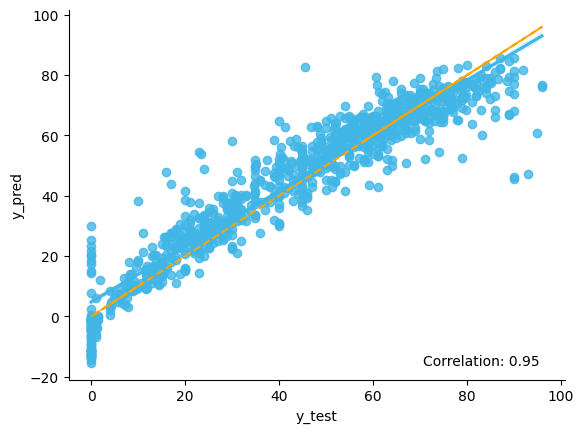

In [26]:
from sklearn.metrics import mean_squared_error

model.to('cpu')
model.eval()

y_pred = model.predict(test_dataset.x, test_dataset.additional).detach()

df = pd.DataFrame(index=test_dataset.input_df.index)

y_test_p = transform_prediction(age['response'])



df['y_test'] =  y_test_p
df['y_pred'] = [x.item() for x in y_pred]


sns.regplot(data=df, x='y_test', y='y_pred', color='#41B6E6')
correlation_coefficient = round(df['y_test'].corr(df['y_pred']), 2)
plt.text(0.95, 0.05, f'Correlation: {correlation_coefficient}', ha='right', va='center', transform=plt.gca().transAxes)
plt.plot(y_test_p, y_test_p, color='#FFA300', linestyle='--', label='Diagonal Line')
sns.despine()
plt.show()

In [27]:
gene_feature_importances, additional_feature_importances, gene_importances, layer_importance_scores = model.interpret(test_dataset)
layer_list = [gene_feature_importances, additional_feature_importances, gene_importances] + layer_importance_scores
layer_list_names = ['gene_feature', 'additional_feature', 'gene'] + [f'layer_{i}' for i in range(5)]
layer_list_dict = dict(zip(layer_list_names, layer_list))

In [28]:
layer_list_dict.pop('additional_feature', None)


""
GSM492458
db23dcfc-0126-49c5-9705-6e1b79fc7df1
GSM501517
GSM401855
GSM635685
...
GSM908395
GSM908467
GSM845995
GSM401863


In [ ]:
all_imps = pd.DataFrame(columns=['Importance', 'Layer'])
for l in layer_list_dict:
    df_imps_t = layer_list_dict[l].reset_index()
    df_imps_t['index2'] = df_imps_t.index
    df_imps = df_imps_t.melt(id_vars='Sample_Barcode', var_name='Gene/Pathway', value_name='Importance').rename(columns={'index': 'Sample'})
    df_imps['Layer'] = l
    all_imps = pd.concat([all_imps, df_imps])
grouped_imps = pd.DataFrame(all_imps.groupby(['Gene/Pathway', 'Layer'])['Importance'].mean().abs().reset_index())
grouped_imps.to_csv(path_or_buf = "xai_test.csv")
pd.Series.append = pd.Series._append
test_dataset_vis = test_dataset
test_dataset_vis.input_df.index.name = None


In [ ]:
%cd /content/pnet/notebooks

/content/pnet/notebooks


In [ ]:
Pnet.evaluate_interpret_save(model, test_dataset, '../results/xai_test/')


In [ ]:
savepath = '../results/xai_test.html'
sk = sankey_diag.SankeyDiag(imps = "../results/xai_test/", runs=1,target = None) # If you want more nodes, change it (self.nbr_displayed = 5) in the /content/pnet/src/util/sankey_diag.py file (will be implemented later in a nicer way)
fig = sk.get_sankey_diag(savepath)